In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
sns.set_style('darkgrid')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)


print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TF version: 2.12.0
Hub version: 0.12.0
GPU is available


Data preparation

In [9]:
datagen_kwargs = dict(rescale=1./255)
dataflow_kwargs = dict(target_size=(224,224), batch_size=128,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.1,
   **datagen_kwargs)


valid_generator = valid_datagen.flow_from_directory(
    '/kaggle/input/dataset/val',
    shuffle = False,
    **dataflow_kwargs
)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2, validation_split=0.1,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen


train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dataset/train', shuffle=True, **dataflow_kwargs)

Found 120 images belonging to 2 classes.
Found 4946 images belonging to 2 classes.


In [14]:
# Making sure the data is shaped properly
x_train, y_train = next(train_generator)
x_valid, y_valid = next(valid_generator)

print("Training Data Shapes:", x_train.shape, y_train.shape)
print("Validation Data Shapes:", x_valid.shape, y_valid.shape)


Training Data Shapes: (128, 224, 224, 3) (128, 2)
Validation Data Shapes: (120, 224, 224, 3) (120, 2)


Model spec

In [28]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
        
        # CNN layer 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        
        # CNN layer 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        
        # CNN layer 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.016)),
        tf.keras.layers.Dropout(rate=0.4, seed=42),
        
        tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    #model.build((None,)+(224, 224)+(3,))
    model.summary()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss= 'categorical_crossentropy',
        metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                      

In [17]:
#Directory to store tensorboard data
if not os.path.exists("/kaggle/working/logs"):
    os.mkdir("/kaggle/working/logs")

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.05, verbose=0)
plateau= tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss', factor= 0.2, patience= 4, verbose= 0, mode= 'min')
tensorboard= tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

In [30]:
with tf.device('/GPU:0'):
    hist = model.fit(
        train_generator,
        epochs=100,
        verbose= 1,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        callbacks=[early_stopping, plateau, tensorboard],
        shuffle= False
    )

Epoch 1/100
38/38 [==============================] - 140s 3s/step - loss: 14.2341 - accuracy: 0.6155 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 123s 3s/step - loss: 5.5259 - accuracy: 0.6517 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 122s 3s/step - loss: 2.3914 - accuracy: 0.6651 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 123s 3s/step - loss: 1.3529 - accuracy: 0.6741 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 122s 3s/step - loss: 0.9900 - accuracy: 0.6795 - lr: 0.0010
Epoch 6/100
38/38 [==============================] - 122s 3s/step - loss: 0.8109 - accuracy: 0.7085 - lr: 0.0010
Epoch 7/100
38/38 [==============================] - 122s 3s/step - loss: 0.7838 - accuracy: 0.7101 - lr: 0.0010
Epoch 8/100
38/38 [==============================] - 122s 3s/step - loss: 0.7134 - accuracy: 0.7190 - lr: 0.0010
Epoch 9/100
38/38 [==============================] - 121s 3s/step - loss: 0.6876 - accuracy: 0.

In [31]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   **datagen_kwargs)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dataset/test',
    shuffle = False,
    **dataflow_kwargs
)

preds = model.evaluate(test_generator)
preds = (model.predict(test_generator) > 0.5).astype("int32")

Found 126 images belonging to 2 classes.
1/1 [==============================] - 8s 8s/step


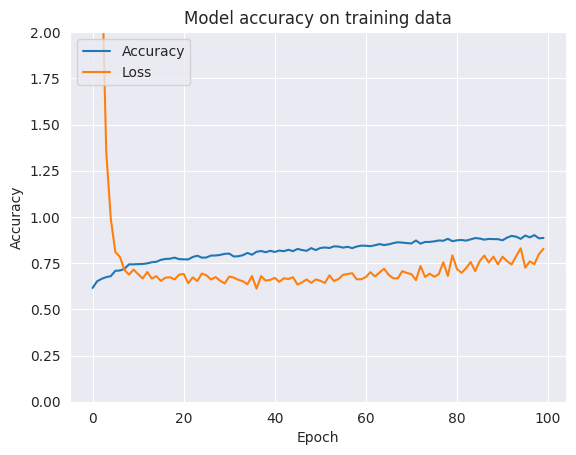

In [32]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(hist.history['accuracy'])import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your true labels in 'y_true' and predicted probabilities in 'y_pred_probs'

# Define a function to calculate the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)

# Plot the ROC curve
plot_roc_curve(fpr, tpr)
plt.plot(hist.history['loss'])
plt.title('Model accuracy on training data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 2])
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

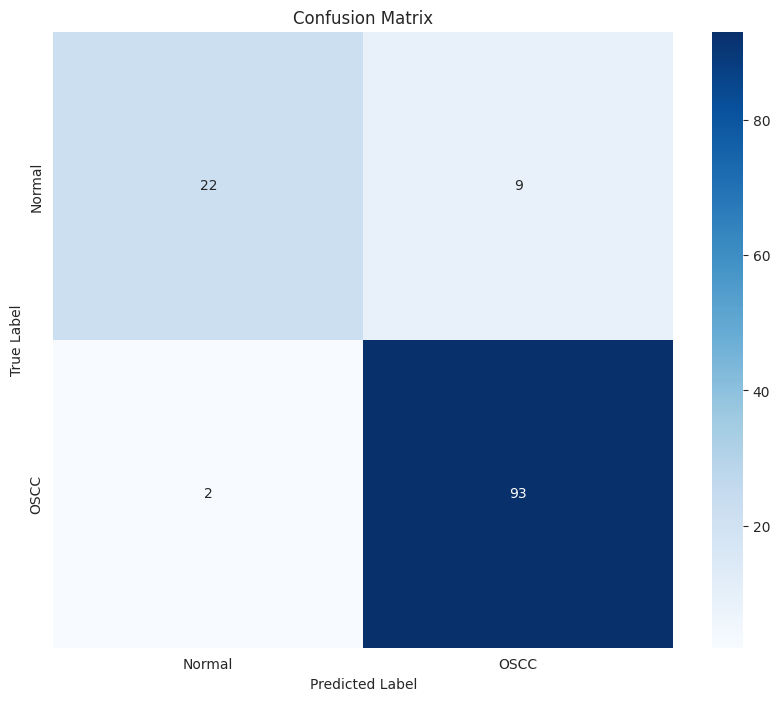

              precision    recall  f1-score   support

      Normal       0.92      0.71      0.80        31
        OSCC       0.91      0.98      0.94        95

    accuracy                           0.91       126
   macro avg       0.91      0.84      0.87       126
weighted avg       0.91      0.91      0.91       126



In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true_labels = test_generator.classes
y_pred_labels = np.argmax(preds, axis=1)

class_names = list(test_generator.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

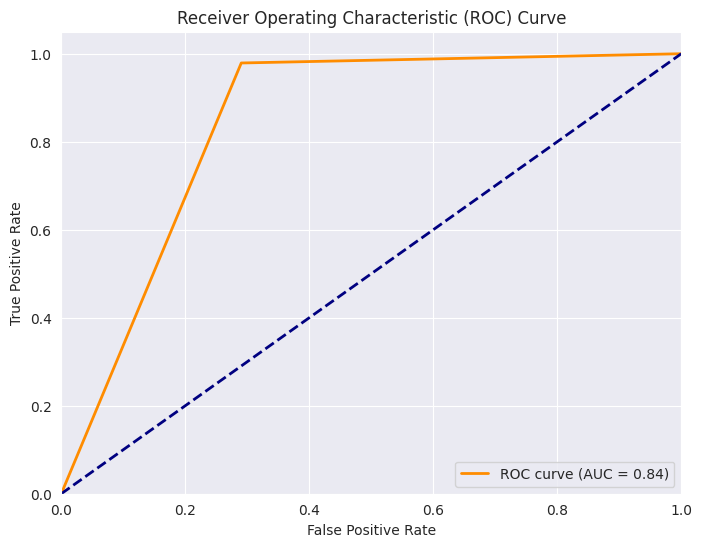

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your true labels in 'y_true' and predicted probabilities in 'y_pred_probs'

# Define a function to calculate the ROC curve
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true_labels, y_pred_labels)

# Plot the ROC curve
plot_roc_curve(fpr, tpr)

In [35]:
model.save_weights("VanillaCNN.h5")

In [36]:
saved_model_path = "/kaggle/working"

# Save the model in the SavedModel format
tf.saved_model.save(model, saved_model_path)